Questions:
1) Why does the random forest regressor het a NRMSE of lower than 1?
2) Maybe connected to (1), why does RF show a better performance metric?

In [48]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

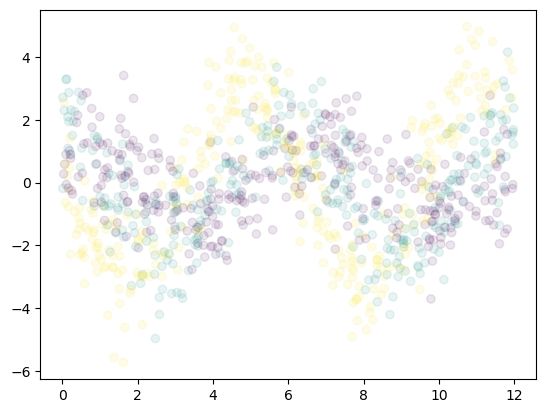

In [50]:
# Constants
N = 1000

# Generate random data
x = np.random.uniform(0, 12, size=N)
c = np.random.randint(1, 4, size=N)
noise = np.random.normal(0, 1, size=N)

# Map integers to labels
label_mapping = {1: "A", 2: "B", 3: "C"}
C_labels = np.vectorize(label_mapping.get)(c)

# Generate y values based on sine function
y_real = c * np.sin(x + c)
y = y_real + noise

# Create DataFrame
data = pd.DataFrame({"x": x, "y": y, "C": c})

# Encode labels
label_encoder = LabelEncoder()
data['C_encoded'] = label_encoder.fit_transform(data['C'])

# Define features and target
features = ['x', 'C']
X = data[features]
y = data['y']

# Plot data
plt.scatter(data.x, data.y, c=c, alpha=0.1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_predict = X_train.copy()
X_test_predict = X_test.copy()

X_test_predict["yNoNoise"] = X_test_predict["C"] * np.sin(X_test_predict["x"] + X_test_predict["C"])
X_test_predict

,x,C,yNoNoise
521,11.294504,2,1.330955
737,8.901857,1,-0.459186
740,0.825575,3,-1.895653
660,7.970605,3,-2.999065
411,10.015631,1,-0.999799
...,...,...,...
408,0.143685,2,1.680677
332,0.135250,3,0.019028
208,0.849671,2,0.575586
613,10.646391,1,-0.795590


Fitting XGB model

<Axes: xlabel='x', ylabel='yNoNoise'>

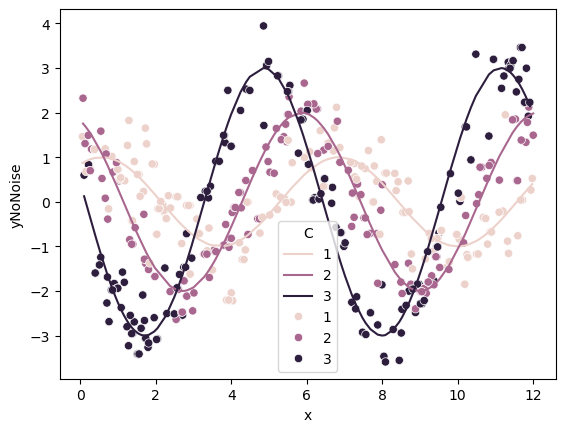

In [20]:
xgbModel = xgb.XGBRegressor(enable_categorical=True)
xgbModel.fit(X_train, y_train)

X_train_predict["yPredXgb"] = xgbModel.predict(X_train)
X_test_predict["yPredXgb"] = xgbModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredXgb", hue="C")

In [152]:
scoresXgb = cross_val_score(xgbModel, X_train, y_train, cv=6, scoring="neg_mean_squared_error").mean()
scoresXgb

-1.3176907834873806

Fitting Random Forest model

<Axes: xlabel='x', ylabel='yNoNoise'>

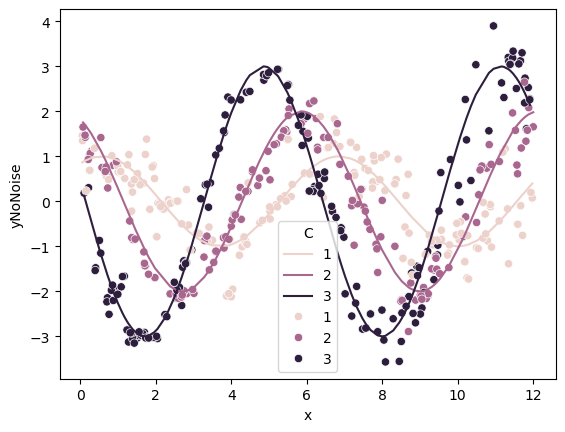

In [21]:
rfModel = RandomForestRegressor(n_estimators=50, 
                                max_depth=10)
rfModel.fit(X_train, y_train)

X_train_predict["yPredRf"] = rfModel.predict(X_train)
X_test_predict["yPredRf"] = rfModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredRf", hue="C")

In [153]:
scoresRf = cross_val_score(rfModel, X_train, y_train, cv=6, scoring="neg_mean_squared_error")
scoresRf.mean()

-1.2075238385691707

Fitting a single tree

<Axes: xlabel='x', ylabel='yPredTree'>

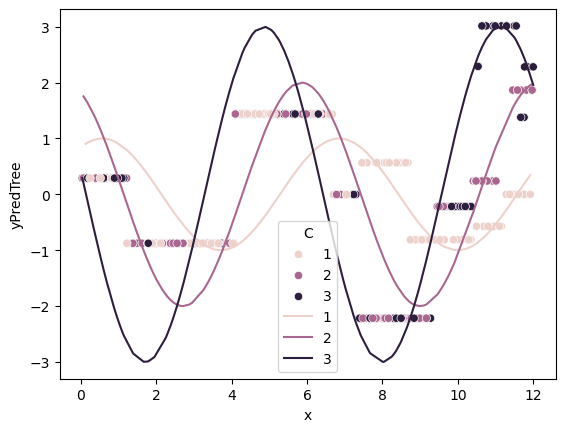

In [149]:
modelTree = RandomForestRegressor(n_estimators=1, max_depth=4)
modelTree.fit(X_train, y_train)

X_train_predict["yPredTree"] = modelTree.predict(X_train)
X_test_predict["yPredTree"] = modelTree.predict(X_test)

sns.scatterplot(data=X_test_predict, x="x", y="yPredTree", hue="C")
sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")

Support Vector Regression

<Axes: xlabel='x', ylabel='yNoNoise'>

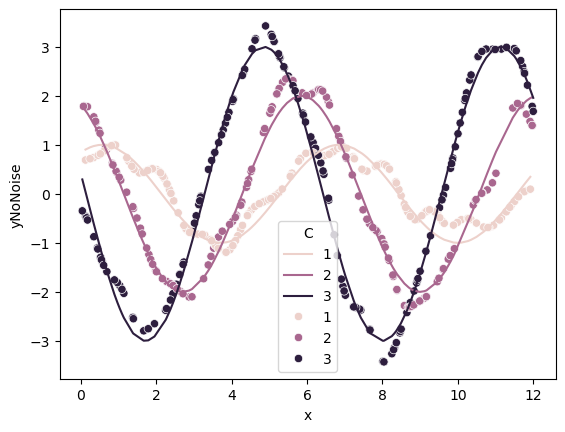

In [166]:
num_values = np.arange(0.1, 0.7, 0.01)
paramGridSvr = {'gamma': num_values}

grid_search = GridSearchCV(estimator=svrModel, 
                           param_grid=paramGridSvr, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=3, 
                           return_train_score=True, 
                           scoring="neg_root_mean_squared_error")

grid_search.fit(X_train, y_train)

scores_mean_train = grid_search.cv_results_["mean_train_score"]
scores_mean_test = grid_search.cv_results_["mean_test_score"]

_, ax = plt.subplots(1,2)

for idx, val in enumerate(num_values):
    ax[0].plot(num_values, scores_mean_train, '-o')
    ax[1].plot(num_values, scores_mean_test, '-o')

ax[0].set_ylabel('CV Average Score')
for i in range(2):
    ax[i].set_title("Grid Search Scores")
    ax[i].set_xlabel("gamma")
    ax[i].legend(loc="best")
    ax[i].grid('on')

svrHyper = grid_search.best_estimator_.gamma

Finetuning SVR model for parameter gamma

<Axes: xlabel='x', ylabel='yNoNoise'>

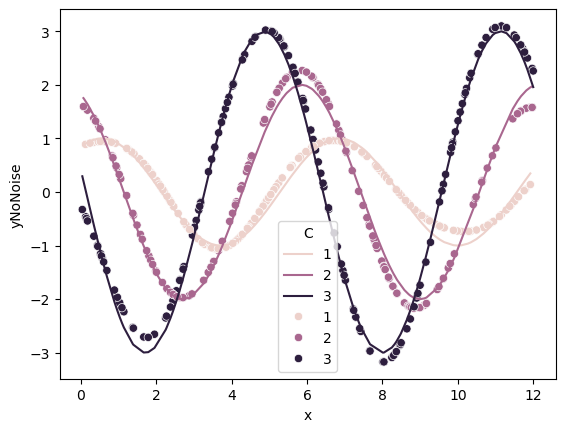

In [188]:
svrModel = SVR(kernel="rbf", gamma=svrHyper)
svrModel.fit(X_train, y_train)

X_train_predict["yPredSvr"] = svrModel.predict(X_train)
X_test_predict["yPredSvr"] = svrModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredSvr", hue="C")

In [ ]:
scores_mean_train = grid_search.cv_results_["mean_train_score"]
scores_mean_test = grid_search.cv_results_["mean_test_score"]

scores_mean_train = np.array(scores_mean_train).reshape(len(max_depth), len(num_values))
scores_mean_test = np.array(scores_mean_test).reshape(len(max_depth), len(num_values))

_, ax = plt.subplots(1,2)

for idx, val in enumerate(max_depth):
    ax[0].plot(num_values, scores_mean_train[idx,:], '-o', label= "max_depth" + ': ' + str(val))
    ax[1].plot(num_values, scores_mean_test[idx,:], '-o', label= "max_depth" + ': ' + str(val))

ax[0].set_ylabel('CV Average Score')
for i in range(2):
    ax[i].set_title("Grid Search Scores")
    ax[i].set_xlabel("n_trees")
    ax[i].legend(loc="best")
    ax[i].grid('on')

In [122]:
X_train_predict["y"] = y_train
X_test_predict["y"] = y_test

X_train_predict["yNoNoise"] = X_test_predict["C"] * np.sin(X_train_predict["x"]+X_train_predict["C"])
X_test_predict["yNoNoise"] = X_test_predict["C"] * np.sin(X_test_predict["x"]+X_test_predict["C"])

<Axes: xlabel='x', ylabel='yPredXgb'>

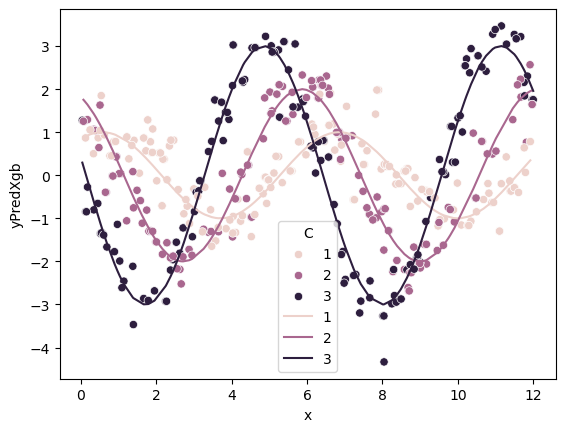

In [124]:
# sns.scatterplot(data=X_test_predict, x="x", y="y", hue="C", alpha=0.1)
sns.scatterplot(data=X_test_predict, x="x", y="yPredXgb", hue="C")
sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")

Tuning hyperparaemeters

In [94]:
num_values = np.arange(5, 75, 3)
max_depth = [3,4,5]

param_grid = {'n_estimators': num_values,
              "max_depth": max_depth}

In [95]:
grid_search = GridSearchCV(estimator=xgbModel, 
                           param_grid=param_grid, 
                           cv=10, 
                           n_jobs=-1, 
                           verbose=3, 
                           return_train_score=True, 
                           scoring="neg_root_mean_squared_error")

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 59}
Best Cross-Validation Score: -1.0438700329829627


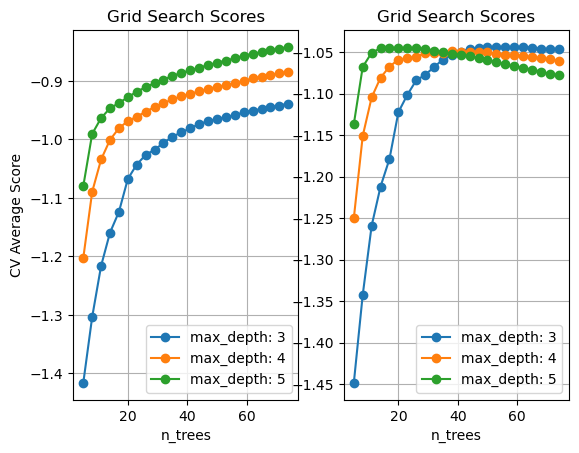

In [96]:
scores_mean_train = grid_search.cv_results_["mean_train_score"]
scores_mean_test = grid_search.cv_results_["mean_test_score"]

scores_mean_train = np.array(scores_mean_train).reshape(len(max_depth), len(num_values))
scores_mean_test = np.array(scores_mean_test).reshape(len(max_depth), len(num_values))

_, ax = plt.subplots(1,2)

for idx, val in enumerate(max_depth):
    ax[0].plot(num_values, scores_mean_train[idx,:], '-o', label= "max_depth" + ': ' + str(val))
    ax[1].plot(num_values, scores_mean_test[idx,:], '-o', label= "max_depth" + ': ' + str(val))

ax[0].set_ylabel('CV Average Score')
for i in range(2):
    ax[i].set_title("Grid Search Scores")
    ax[i].set_xlabel("n_trees")
    ax[i].legend(loc="best")
    ax[i].grid('on')

Plotting VIP plots of the three models

In [143]:
rfModel.feature_importances_, xgbModel.feature_importances_, treeModel.feature_importances_


NameError: name 'treeModel' is not defined

Here we try other strategies for hyperparameter tuning

In [128]:
import optuna

# Define the objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', low=0.001, high=0.1, log=True),
        'subsample': trial.suggest_float('subsample', low=0.5, high=1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', low=0.5, high=1.0)
    }
    
    model = xgb.XGBRegressor(**param)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print best parameters
print(study.best_params)

[I 2024-06-14 14:26:18,108] A new study created in memory with name: no-name-9053fd8a-dd25-411d-9e3d-61f54dbe4ffd
[I 2024-06-14 14:26:18,278] Trial 0 finished with value: -2.330096274225777 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.08737942510414912, 'subsample': 0.9429723242773398, 'colsample_bytree': 0.6361115501311626}. Best is trial 0 with value: -2.330096274225777.
[I 2024-06-14 14:26:18,523] Trial 1 finished with value: -2.3969040171661655 and parameters: {'n_estimators': 177, 'max_depth': 2, 'learning_rate': 0.024849108156114564, 'subsample': 0.8013213987957658, 'colsample_bytree': 0.6167676101305196}. Best is trial 0 with value: -2.330096274225777.
[I 2024-06-14 14:26:18,874] Trial 2 finished with value: -2.4143804832893787 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.01123913422253927, 'subsample': 0.5322774595849649, 'colsample_bytree': 0.8264849598586927}. Best is trial 0 with value: -2.330096274225777.
[I 2024-06-14 

{'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.08904209877968702, 'subsample': 0.5568890622027937, 'colsample_bytree': 0.7130778197707641}


Gaussian Process Regression

In GPR, the kernels (and weights thereof are hyperparameters)

Let op: de banden werkt op het moment enkel met één variabele. Is vast mogelijk met meerdere maar is nu erg veel moeite

The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


<Axes: xlabel='x', ylabel='yNoNoise'>

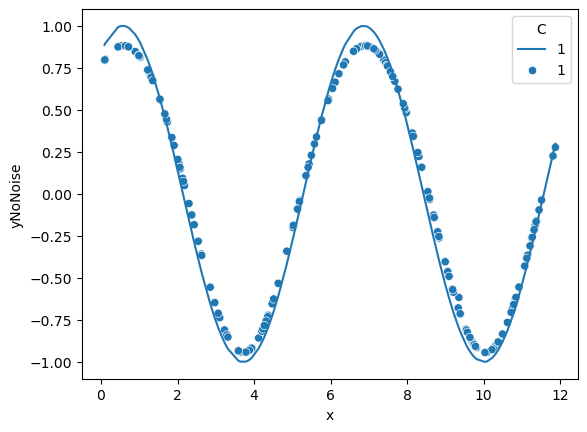

In [59]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared

kernel = (
    ExpSineSquared(length_scale=1.0, periodicity=1.0) + RBF(length_scale=1.0) + ConstantKernel(1)
)

gprModel = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gprModel.fit(X_train, y_train)

X_train_predict["yPredGpr"] = gprModel.predict(X_train)
X_test_predict["yPredGpr"] = gprModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredGpr", hue="C")

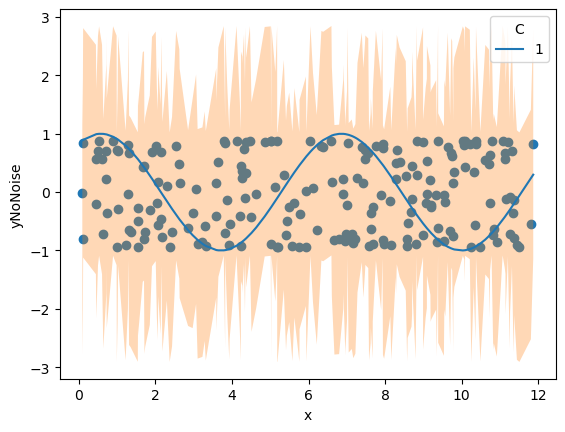

In [77]:
gprModelMean, gprModelStd = gprModel.predict(X_test, return_std=True)

X_test_predict["gprModelMean"] = gprModelMeanp
X_test_predict["gprModelStd"] = gprModelStd

X_test_predict = X_test_predict.sort_values(by="x")

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")p
# sns.scatterplot(data=X_test_predict, x="x", y="yPredGpr", hue="C")

plt.scatter(x=X_test_predict["x"], y=X_test_predict["gprModelMean"])
plt.fill_between(
    X_test_predict["x"],
    X_test_predict["gprModelMean"] - 1.96 * X_test_predict["gprModelStd"],
    X_test_predict["gprModelMean"] + 1.96 * X_test_predict["gprModelStd"],
    alpha=0.3,
    data=X_test_predict
)
# plt.legend()
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# _ = plt.title("Gaussian process regression on noise-free dataset")

In [62]:
X_test_predict

,x,C,yNoNoise,yPredGpr
521,8.575161,1,-0.149817,-0.019428
737,3.226966,1,-0.884478,-0.808968
740,7.223441,1,0.932523,0.844358
660,1.544708,1,0.562069,0.559362
411,5.011746,1,-0.268118,-0.198868
...,...,...,...,...
408,8.704342,1,-0.275937,-0.139627
332,9.784422,1,-0.977790,-0.906792
208,10.030996,1,-0.999373,-0.943220
613,2.852357,1,-0.652413,-0.554769


In [40]:
X_test

,x,C
521,10.940985,3
737,0.510942,3
740,5.985516,2
660,5.088993,1
411,5.231288,2
...,...,...
408,11.239787,3
332,1.472430,2
208,5.365688,2
613,3.586654,1


GPR with Matern kernel. In the first chunk, we fit a model. In the second we plot including confidence bounds

In [4]:
from sklearn.gaussian_process.kernels import Matern

kernel = (
    ConstantKernel(1) * ExpSineSquared(length_scale=1.0, periodicity=2.0) +
    RBF(1)
)

gprModel = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gprModel.fit(X_train, y_train)

X_train_predict["yPredGpr"] = gprModel.predict(X_train)
X_test_predict["yPredGpr"] = gprModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredGpr", hue="C")

Plotting the confidence bounds, including some sampled functions

And something else..

In [39]:
wineData = pd.read_csv("C:/Users/gouwenss/OneDrive - rivm.nl/Desktop/Programming/Data/winequality-red.csv", sep=";")

X = wineData.drop(columns=['quality'])
y = wineData['quality']

wineDataTrain, _, wineDataTest, _ = train_test_split(X, y, test_size=0.01, random_state=42)

In [40]:
rfWineModel = RandomForestClassifier()

In [41]:
num_values = np.arange(5, 150, 3)
max_depth = [3,4,5,6,7,8]

param_grid = {'n_estimators': num_values,
              "max_depth": max_depth}

grid_search = GridSearchCV(estimator=rfWineModel, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=3, 
                           return_train_score=True, 
                           scoring="neg_root_mean_squared_error")

grid_search.fit(wineDataTrain, wineDataTest)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': array([  5,   8,  11,  14,  17,  20,  23,  26,  29,  32,  35,  38,  41,
        44,  47,  50,  53,  56,  59,  62,  65,  68,  71,  74,  77,  80,
        83,  86,  89,  92,  95,  98, 101, 104, 107, 110, 113, 116, 119,
       122, 125, 128, 131, 134, 137, 140, 143, 146, 149])},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=3)

In [50]:
optimHyperparameters = grid_search.best_params_

rfWineModelOptim = RandomForestRegressor(**optimHyperparameters)

rfWineModelOptim.fit(X, y)

RandomForestRegressor(max_depth=8, n_estimators=80)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


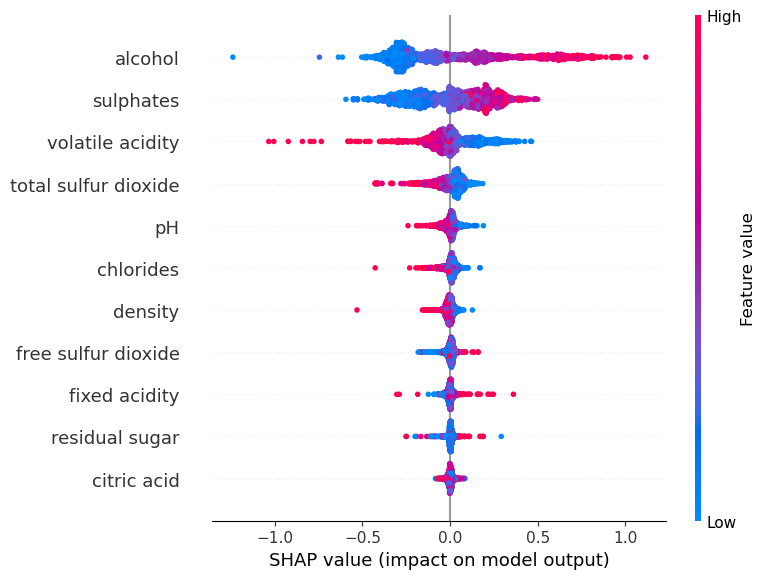

IndexError: index 1 is out of bounds for axis 0 with size 1

In [51]:
explainer = shap.TreeExplainer(rfWineModelOptim)

shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0,:])

<Axes: xlabel='x', ylabel='yNoNoise'>

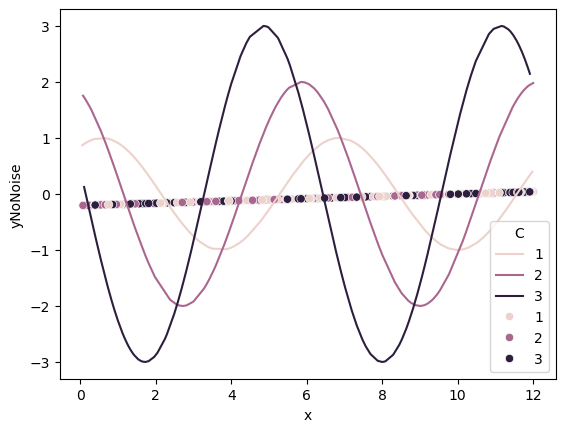

In [22]:
from sklearn.linear_model import ElasticNet

enModel = ElasticNet()
enModel.fit(X_train, y_train)

X_train_predict["yPredEn"] = enModel.predict(X_train)
X_test_predict["yPredEn"] = enModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredEn", hue="C")

Kernel Ridge Regression (KRR)

<Axes: xlabel='x', ylabel='yNoNoise'>

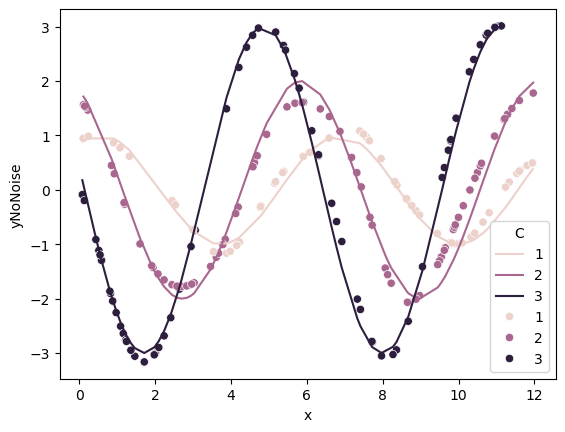

In [52]:
from sklearn.kernel_ridge import KernelRidge

kdeModel = KernelRidge(kernel="rbf")
kdeModel.fit(X_train, y_train)

X_train_predict["yPredKde"] = kdeModel.predict(X_train)
X_test_predict["yPredKde"] = kdeModel.predict(X_test)

sns.lineplot(data=X_test_predict, x="x", y="yNoNoise", hue="C")
sns.scatterplot(data=X_test_predict, x="x", y="yPredKde", hue="C")

In [47]:
X_test_predict["C"].value_counts()

C
1    200
Name: count, dtype: int64

Nadaraya-watson-regression